<a href="https://colab.research.google.com/github/kmayutrisna/SA_IMDB/blob/main/2_IMDB_word2vec_CNN_Base_USE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install --upgrade gensim nltk matplotlib seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install nltk
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#DATA PREPARATION
# Importing essential libraries and functions
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Download stopwords and word tokenizer
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**DATA COLLECTION**

In [6]:
#Get the dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Display top of data
data =pd.read_csv("drive/My Drive/data/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
#Display shape and data info
data.review.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [9]:
# Checking for missing values
data.isnull().values.any()

False

In [8]:
# Text preprocessing
import re
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if not word in stop_words]
    text = ' '.join(text)
    return text

data['review'] = data['review'].apply(preprocess_text)

In [9]:
# Convert sentiment to binary labels
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})
y = data['sentiment']

In [10]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['review'])
sequences = tokenizer.texts_to_sequences(data['review'])
word_index = tokenizer.word_index

In [11]:
# Define the maximum sequence length
max_length = 100

In [12]:
# Pad sequences to have the same length
padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [13]:
# Split the dataset into training, validation, and testing sets
X = padded_sequences
y = data['sentiment']
split_index_train = int(0.8 * len(X))
split_index_val = int(0.9 * len(X))
X_train, X_val, X_test = X[:split_index_train], X[split_index_train:split_index_val], X[split_index_val:]
y_train, y_val, y_test = y[:split_index_train], y[split_index_train:split_index_val], y[split_index_val:]

In [45]:
y_train[2]

1

In [14]:
import gensim
from gensim.models import Word2Vec

In [15]:
# Load pre-trained Word2Vec model
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('drive/My Drive/data/GoogleNews-vectors-negative300.bin', binary=True)

In [16]:
# Create embedding matrix
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1

In [17]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in w2v_model:
        embedding_matrix[i] = w2v_model[word]

In [18]:
# Build the CNN model
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [19]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [21]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, callbacks=[early_stopping])

Epoch 1/10
313/313 [==============================] - 103s 324ms/step - loss: 0.4124 - accuracy: 0.8091 - val_loss: 0.3220 - val_accuracy: 0.8640
Epoch 2/10
313/313 [==============================] - 90s 286ms/step - loss: 0.2910 - accuracy: 0.8782 - val_loss: 0.3047 - val_accuracy: 0.8738
Epoch 3/10
313/313 [==============================] - 87s 278ms/step - loss: 0.2235 - accuracy: 0.9146 - val_loss: 0.3062 - val_accuracy: 0.8696
Epoch 4/10
313/313 [==============================] - 89s 283ms/step - loss: 0.1574 - accuracy: 0.9492 - val_loss: 0.3141 - val_accuracy: 0.8702
Epoch 5/10
313/313 [==============================] - 89s 284ms/step - loss: 0.0960 - accuracy: 0.9776 - val_loss: 0.3313 - val_accuracy: 0.8726


In [22]:
# Evaluate the model
_, train_accuracy = model.evaluate(X_train, y_train)
_, test_accuracy = model.evaluate(X_test, y_test)

157/157 [==============================] - 7s 44ms/step - loss: 0.3109 - accuracy: 0.8662


In [ ]:
#approach 1
# Obtain predicted probabilities
##y_pred_probs = model.predict(X_test)

# Convert probabilities to predicted labels
y_pred = np.argmax(y_pred_probs, axis=1)

In [32]:
#approach 2
# Predict the test set probabilities
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int).flatten()

157/157 [==============================] - 5s 33ms/step


In [30]:
#approach 3
# Predict the test set probabilities
#y_pred1 = model.predict(X_test)

157/157 [==============================] - 6s 35ms/step


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Calculate evaluation metrics

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8662
Precision: 0.8438335242458954
Recall: 0.8947368421052632
F1-score: 0.8685399882098644


In [34]:
# Plot model performance

def plot_model_performance(history):
    # Accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

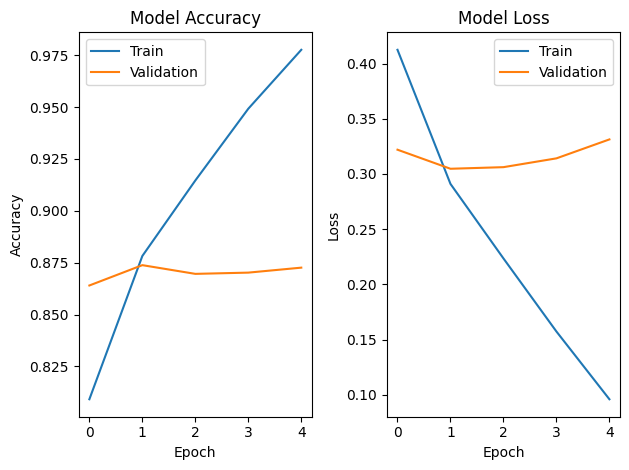

In [35]:
# Plot the model performance
plot_model_performance(history)

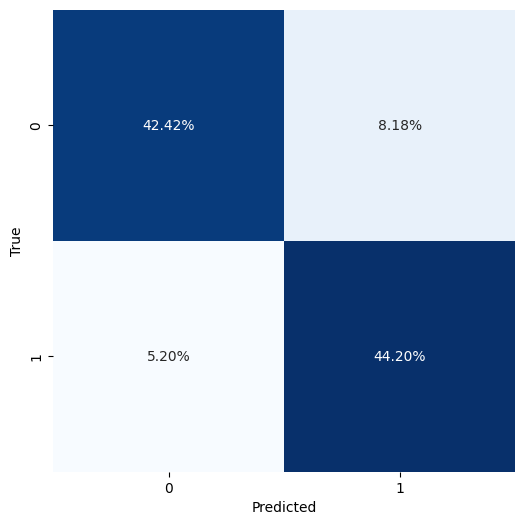

In [36]:
# Calculate the confusion matrix

cm = confusion_matrix(y_test, y_pred_binary)
# Normalize the confusion matrix to display percentages out of the total
cm_norm = cm.astype('float') / cm.sum()

plt.figure(figsize=(6, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()